### Styling

In [1]:
# import vapeplot # https://github.com/dantaki/vapeplot
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import numpy as np

matplotlib.rcParams["figure.dpi"] = 100
matplotlib.rcParams["savefig.dpi"] = 300
# load style sheet for matplotlib, a plotting library we use for 2D visualizations
plt.style.use(
    'https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle'
    )
# plt.style.use(
#     "https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle"
# )
# plt.style.use("dark_background")
grey = 0.22
# grey = 0.75
# plt.rcParams.update(
#     {
#         "figure.facecolor": (grey, grey, grey, 1.0),
#         "axes.facecolor": (grey, grey, grey, 1.0),
#         "savefig.facecolor": (grey, grey, grey, 1.0),
#         "grid.color": (0.4, 0.4, 0.4, 1.0),
#     }
# )
# vapeplot.set_palette("mallsoft")
plt.set_cmap("plasma")

<Figure size 640x480 with 0 Axes>

## Make map with all epws

In [2]:
from utils.constants import EPW_MAP_PATH, EPW_TESTING_LIST_PATH, EPW_TRAINING_LIST_PATH
testing_epw_df = pd.read_csv(EPW_TESTING_LIST_PATH, index_col=0)
training_epw_df = pd.read_csv(EPW_TRAINING_LIST_PATH, index_col=0)

In [3]:
training_epw_df["type"] = "Training"
testing_epw_df["type"] = "Testing"
testing_epw_df.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id,CZ,idx,slug,type
729,Az Zarqā’,Az Zarqa',32.0833,36.1000,Jordan,JO,JOR,Az Zarqā’,admin,481300.0,1400161837,3B,729,cityidx_0729_ISR_--Jerusalem-Atarot AP.401840_...,Testing
305,Ulaanbaatar,Ulaanbaatar,47.9203,106.9172,Mongolia,MN,MNG,Ulaanbaatar,primary,1396288.0,1496024767,7,305,cityidx_0305_MNG_--ULAANBATAAR.442920_IWEC Dat...,Testing
217,Hebi,Hebi,35.7497,114.2887,China,CN,CHN,Henan,NaN,1569208.0,1156114258,4B,217,cityidx_0217_CHN_Henan-Anyang.538980_CSWD.epw,Testing
426,Valencia,Valencia,39.4700,-0.3764,Spain,ES,ESP,Valencia,admin,792492.0,1724981666,3B,426,cityidx_0426_ESP_--VALENCIA.082840_IWEC Data.epw,Testing
552,Bakersfield,Bakersfield,35.3529,-119.0359,United States,US,USA,California,NaN,590845.0,1840019148,3B,552,cityidx_0552_USA_CA-BAKERSFIELD.723840_TMY2-23...,Testing


In [5]:
all_epw_df = pd.concat([testing_epw_df, training_epw_df])
all_epw_df.shape

(879, 15)

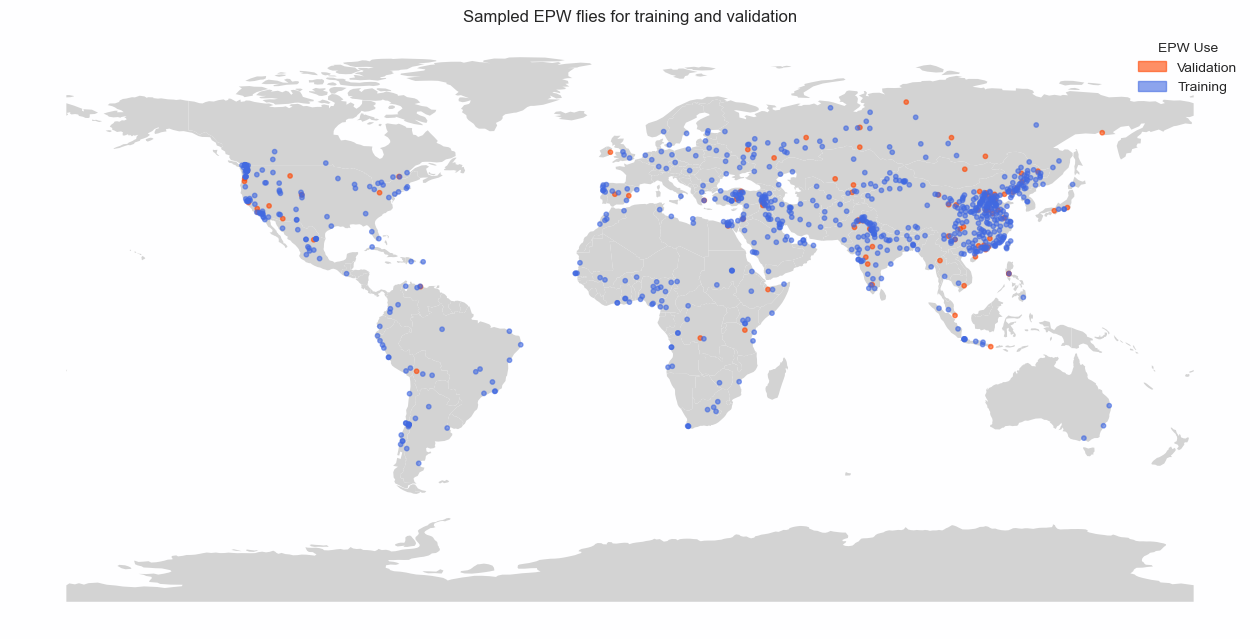

In [108]:
from matplotlib.colors import ListedColormap
from matplotlib.patches import Circle

# Getting world map data from geo pandas
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Creating axes and plotting world map
fig, ax = plt.subplots(figsize=(16, 10))
worldmap.plot(color="lightgrey", ax=ax)

cmap = ListedColormap(["orangered", "royalblue"])

# Plotting tourist source markets
x = all_epw_df['lat']
y = all_epw_df['lng']
l = all_epw_df['type']
z = (all_epw_df['type'] == "Training")*1
scatter = plt.scatter(y, x, 
            c=z,
            s=10,
            alpha=0.6,
            cmap=cmap,

            )
legend_elements = [Circle((0,0), radius=1, color=cmap.colors[0], label='Validation', alpha=0.6),
                   Circle((0,0), radius=1, color=cmap.colors[1], label='Training', alpha=0.6)]

ax.set_facecolor("white")
plt.axis("off")
plt.legend(handles=legend_elements, title="EPW Use")
plt.title("Sampled EPW flies for training and validation")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.savefig("figures/epw_map.png")
plt.show()

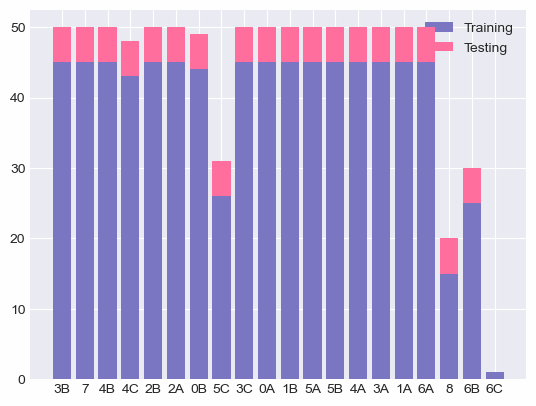

In [79]:
# Plot weather by climate zone bins
czs = all_epw_df['CZ'].unique()
past_h = pd.Series({x:0 for x in czs})
fig, ax = plt.subplots()
for i, type in enumerate(["Training", "Testing"]):
    d = all_epw_df[all_epw_df["type"]==type].groupby(["CZ"]).count()
    h = pd.concat([past_h, d["city"]], axis=1).sum(axis=1)
    ax = plt.bar(x=czs, height=h, label=type, alpha=1, zorder=10-i)
    past_h = h
    plt.legend()

## Training data distributions

## Latent Vector & t-SNE

Looking first at the latent vectors, as our dataset has many (uninterpretable) dimensions/features (22), but we expect there to be some similarities due to aspects such as climate zone, we use Tsne to visualize the intermediate fingerprints of timeseries latent vectors.

In [34]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

flat_fingerprints = np.array(latent_vectors).reshape((16000, 22*12))

pca_embedding = PCA(n_components=10).fit_transform(flat_fingerprints)

In [93]:
pca_embedding.shape

(16000, 10)

In [35]:
embedding_3d = PCA(n_components=2).fit_transform(flat_fingerprints)

(-1.0, 0.0)

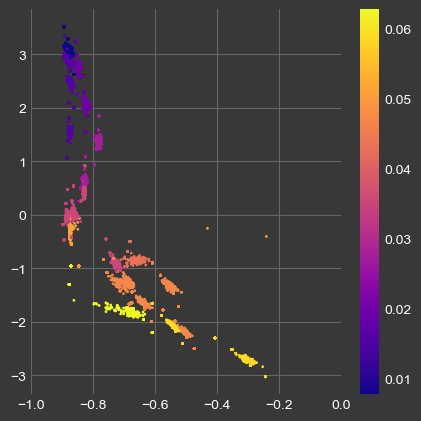

In [104]:
plt.figure(figsize=(5,5))
plt.scatter(embedding_3d[:, 0].tolist(), embedding_3d[:, 1].tolist(), c=colors/255, s=1)
plt.colorbar()
plt.xlim([-1, 0])

In [36]:
perplexity = 1
embedding = TSNE(
    n_components=2, perplexity=perplexity, n_iter=500, init="pca"
    ).fit_transform(flat_fingerprints)

# embedding = TSNE(
#     n_components=2, perplexity=perplexity, n_iter=500, init="pca"
#     ).fit_transform(pca_embedding)

Identify embeddings by climate zone

In [37]:
colors = czs.flatten()

In [40]:
CLIMATEZONES = [
    "0A",
    "0B",
    "1A",
    "1B",
    "2A",
    "2B",
    "3A",
    "3B",
    "3C",
    "4A",
    "4B",
    "4C",
    "5A",
    "5B",
    "5C",
    "6A",
    "6B",
    "7A",
    "8A",
]

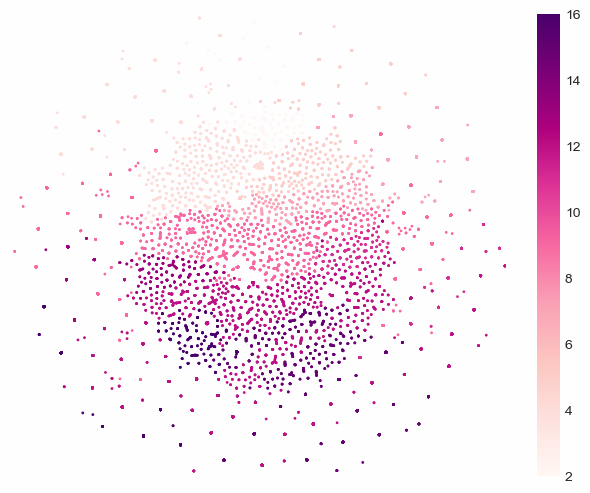

In [51]:
x_min, x_max = min(embedding[:, 0]), max(embedding[:, 0])
y_min, y_max = min(embedding[:, 1]), max(embedding[:, 1])

size = 0.01 * min(x_max-x_min, y_max-y_min)

plt.figure(figsize=(8, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, s=1)
# plt.xlim((x_min - size, x_max + size))
plt.xlim((x_min - size, 60))
plt.ylim((y_min - size, y_max + size))
plt.axis("off")
# Add colorbar, make sure to specify tick locations to match desired ticklabels
cb = plt.colorbar()
# cb.set_yticklabels(CLIMATEZONES)  # vertically oriented colorbar
plt.savefig("pcs2.png")
plt.show()


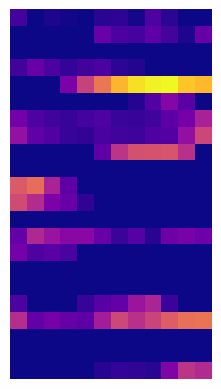

In [57]:
c = CLIMATEZONES.index("1A")
ix = np.random.choice(np.argwhere(czs==c).flatten(), 1)
for i in ix:
    plt.imshow(np.array(latent_vectors[i]))
    # plt.savefig(f"latentv_cz{c}_{i}.png")
    plt.axis("off")
    plt.show()